<a href="https://colab.research.google.com/github/johannpeterson/nijhawanlab/blob/master/amplicon_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook automates the analysis of high-throughput sequencing files from expermiments which submit a batch of combined samples for amplicon sequencing.

The following files are required:
1. Paired-read FASTQ files, e.g. `XXX_R1_001.fastq.gz` & `XXX_R2_001.fastq.gz`
1. Samples table, e.g. `XXX_samples.tsv`.  Discussed under **Samples Table**.
1. `primers.txt`.  This is a tab-delimited table of primers with 4 columns:
  1. `OriginalSeq` - the primer label
  1. `sequence` - the full sequence of the primer
  1. `barcode` - the primer "barcode"
  1. `direction` - the primer direction, either F or R

`XXX` above designates the particular experiment, and is specified in the [`experiment`](#scrollTo=qxgM5A3cSOqV) variable below.

Current version as of 16 Oct 2023.  Duplicate for each analysis.

# Preliminaries

## Experiment-Specific Variables
The following cells should contain all the variables you need to change in order to run this analysis with different data files.  The variable `experiment` below is used to set the working directory and the file names for the FASTQ files and the table of samples.

The `label_prefix` variable specifies the prefix in the primer labels.

In [67]:
experiment = "VK022B"
label_prefix = "oVK"
water_labels = ["W1", "W2", "W3"]

In [2]:
base_directory = "/content/drive/My Drive/nijhawanlab/amplicons/"
data_directory = base_directory + experiment + "/"
source_directory = base_directory + "source/"
R1_file = data_directory + experiment + "_R1_001.fastq.gz"
R2_file = data_directory + experiment + "_R2_001.fastq.gz"
primer_file = data_directory + "primers.txt"
samples_file = data_directory + experiment + "_samples.tsv"

In [3]:
maximum_reads_per_file = 10**6

In [4]:
minimum_read_quality = 20
minimum_barcode_length = 14
maximum_barcode_length = 30

In [5]:
# TTCTTGACGAGTTCTTCTGA
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA'
# ACGCGTCTGGAACAATCAAC
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC'

reference_barcode_pattern = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex_string = r"[AT]?([GC][AT])+[GC]?"
# reference_barcode_regex_string = r"([GC][AT])+"
primer_name_regex_string = r"(" + label_prefix + ")(\d{1,3})"
primer_name_regex_string

'(oVK)(\\d{1,3})'

## Mount the working directory & install modules:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Google Colab does not have BioPython installed:

In [7]:
pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.5 MB/s eta 0:00:00


In [ ]:
# pip install ipdb
# import ipdb

In [8]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
from itertools import cycle
from tqdm import tqdm
from io import StringIO
import locale

## Utility functions


In [9]:
import sys
sys.path.insert(0, source_directory)

In [10]:
%load_ext autoreload
%cd "$source_directory"
# I don't understand why you need to change the working directory if you have added it to the path.
%aimport jpbio.util
%aimport jpbio.quality
%cd "$data_directory"

/content/drive/My Drive/nijhawanlab/amplicons/source
/content/drive/My Drive/nijhawanlab/amplicons/VK022B


# Read Input Files

## Read in primers.txt and store primers in various useful forms

In [11]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(
        primers_IO,
        delimiter='\t',
        fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

primer_lookup = {p['OriginalSeq']:
                 {'len':len(p['sequence']),
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

primer_lookup

{'oVK790': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK803': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK804': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK805': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK806': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK807': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK808': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK809': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK791': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK810': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK811': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

## Primer ID

The `IdPrimers` function finds the primers matching a sequence.  For each primer, it searches starting at the first position in the read sequence for the primer sequence, and starting at the last positiom for the reverse compliment of the primer sequence.  Becuase of the loop, it will return the last matching primer in each direction, and makes no attempt to deal with sequences matching multiple primers.

In [12]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None,
        'rc_primer':None,
        'rc_primer_loc':None,
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( jpbio.util.rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

## Sanity Checking

This cell defines a series of functions (named `sanity_...`), which operate on a `full_read` data structure as returned by the `analyzeReads` function.  Each `sanity_` function returns `True` or `False`, according as the read pair passes the particular quality check.  The `sanity_checks` structure is a list containing one dictionary for each `sanity_` function.  

In [13]:
def sanity_id_match(full_read):
    return full_read['F_id'] == full_read['R_id']

def sanity_primer_match(full_read):
    return (
        (full_read['F_forward_primer'] == full_read['R_rc_primer']) &
        (full_read['F_rc_primer'] == full_read['R_forward_primer'])
    )

def sanity_all_primers_found(full_read):
    return (
        (full_read['F_forward_primer'] != None) &
        (full_read['F_rc_primer'] != None) &
        (full_read['R_forward_primer'] != None) &
        (full_read['R_rc_primer'] != None)
    )

def sanity_barcodes_match(full_read):
    return (full_read['F_barcode'] == full_read['R_barcode'])

def sanity_barcodes_length(full_read):
    lF = len(full_read['F_barcode'])
    lR = len(full_read['R_barcode'])
    return (
        (lF <= maximum_barcode_length) &
        (lF >= minimum_barcode_length) &
        (lR <= maximum_barcode_length) &
        (lR >= minimum_barcode_length)
    )

sanity_barcode_regex = re.compile(reference_barcode_regex_string)
def sanity_barcode_pattern(full_read):
    if sanity_barcode_regex.fullmatch(full_read['F_barcode']):
        return True
    else:
        return False

def sanity_barcodes_quality(full_read):
    return (
        (min(full_read['F_quality']) >= minimum_read_quality) &
        (min(full_read['R_quality']) >= minimum_read_quality)
    )

sanity_checks = [
    {
        'id':'any',
        'label':'Any Check',
        'description':'Read pairs failing any sanity check.',
        'function':(lambda _: True)
    },
    {
        'id':'id_match',
        'label':'IDs Match',
        'description':'R1 & R2 read IDs match.',
        'function':sanity_id_match
    },
    {
        'id':'primer_match',
        'label':'Primers Match',
        'description':'Forward & reverse primers for R1 & R2 match.',
        'function':sanity_primer_match
    },
    {
        'id':'primers_found',
        'label':'Primers Found',
        'description':'Forward & reverse primers identified in both reads.',
        'function':sanity_all_primers_found
    },
    {
        'id':'barcodes_match',
        'label':'Barcodes Match',
        'description':'Barcodes from R1 & R2 reads match exactly.',
        'function':sanity_barcodes_match
    }
#    {
#        'id':'barcode_length',
#        'label':'Barcode Length',
#        'description':'Barcode lengths are within the required range.',
#        'function':sanity_barcodes_length
#    },
#    {
#        'id':'barcode_pattern',
#        'label':'Barcode Pattern',
#        'description':'The R1 barcode matches the specified pattern (SWSW...).',
#        'function':sanity_barcode_pattern
#    },
#    {
#        'id':'barcodes_quality',
#        'label':'Barcode Read Quality',
#        'description':'The minimum read quality (PHRED score) for both barcodes is at least the minumum specified.',
#        'function':sanity_barcodes_quality
#    }
]

## Analyze Read
Identify the direction of the reads, forward & reverse primers, barcode location & sequence.  The `analyzeReads` function returns a dictionary structure with elements for the read IDs, forward and reverse compliment primers for each read, locations in the reads for the barcodes, the barcode sequences and the sequences of quality scores corresponding to the barcodes.

In [14]:
def analyzeReads(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = F_primers['rc_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = R_primers['rc_primer']

    r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    r['F_barcode_loc'] = [r['F_pre_loc']+len(reference_sequence_pre), r['F_post_loc']]
    r['R_barcode_loc'] = [r['R_post_loc']+len(reference_sequence_post), r['R_pre_loc']]
    r['F_barcode'] = str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]]
    r['R_barcode'] = jpbio.util.rcDNA( str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ] )

    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]

    return r



This function (`analyzeReadsAndFillInPrimers`) is a modified version of the function above, to allow for pairs of reads that do not overlap enough to have both primers on each read in the pair.  It could use some fixing up, as it currently makes assumptions about the direction of the reads which work for the JK001 experiment but may not be valid in general.

In [15]:
def analyzeReadsAndFillInPrimers(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = R_primers['fwd_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = F_primers['fwd_primer']

    r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    # r['F_pre_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    # r['F_post_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    # r['R_pre_loc'] = R_read.seq.find(reference_sequence_pre)
    # r['R_post_loc'] = R_read.seq.find(reference_sequence_post)
    r['F_barcode_loc'] = [r['F_pre_loc']+len(reference_sequence_pre), r['F_post_loc']]
    r['R_barcode_loc'] = [r['R_post_loc']+len(reference_sequence_post), r['R_pre_loc']]

    # r['F_barcode_loc'] = [r['F_post_loc']+len(reference_sequence_post), r['F_pre_loc']]
    # r['R_barcode_loc'] = [r['R_pre_loc']+len(reference_sequence_pre), r['R_post_loc']]
    r['F_barcode'] = jpbio.util.rcDNA( str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]] )
    r['R_barcode'] = str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]

    # print(r['F_barcode'])
    # print(r['R_barcode'])

    # print(F_read.seq)
    # print(R_read.seq)

    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]

    return r

## Figure out how many sequences are in each file

This runs separate processes to decompress and count lines in the input fastq files.  If it takes too much time, it can be skipped, but it doesn't take very long compared with processing the files below.  The advantage of running it is that the progress bar during processing accurately reflects how many sequences there are.

If [`maximum_reads_per_file`](#scrollTo=EhIRApjv_PzZ) is set to a smaller number than the number of reads in the FASTQ files, then only read that many pairs.

In [16]:
R1_lines = !cat "$R1_file" | gunzip | wc -l
R2_lines = !cat "$R2_file" | gunzip | wc -l

In [17]:
import math

reads_in_files = int(math.ceil( max( int(R1_lines[0])/4, int(R2_lines[0])/4) ))
if reads_in_files > maximum_reads_per_file:
  print("Warning: the files will not be read in full.")
  print("There are {} read pairs in the files, and only {} read pairs will be processed.".format(
        reads_in_files, maximum_reads_per_file)
  )
else:
  maximum_reads_per_file = reads_in_files

## Load paired reads from FASTQ files
This is the code that loops through the paired read FASTQ files.  It is the most time-consuming part of the process.  It runs at about 1100 sequence pairs per second (on the free tier of Google Colab), so it will take about 15 minutes to process 1 million paired reads.

In [18]:
with gzip.open(R1_file, "rt") as R1, gzip.open(R2_file, "rt") as R2:
  reads1 = SeqIO.parse(R1, "fastq")
  reads2 = SeqIO.parse(R2, "fastq")
  maxReads = maximum_reads_per_file
  readNumber = 1
  reads_list = []
  R1_quality = jpbio.quality.QualityStatistics()
  R2_quality = jpbio.quality.QualityStatistics()

  sanity_failures = {i['id']:0 for i in sanity_checks}

  progress_bar = tqdm(total=maxReads)
  for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)

    # identify the primers and analyze the read pair
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    if R1_primers['fwd_direction'] == 'F':
      full_read = analyzeReadsAndFillInPrimers(read1, read2, R1_primers, R2_primers)
    else:
      full_read = analyzeReadsAndFillInPrimers(read2, read1, R2_primers, R1_primers)

    # quality checks on the read pair
    any_failure = False
    for check in sanity_checks:
      try:
          test_passes = check['function'](full_read)
      except ValueError:
          test_passes = False
      if not test_passes:
          sanity_failures[check['id']] += 1
          any_failure = True
    if any_failure:
      sanity_failures['any'] += 1
    else:
      reads_list.append(
          {'barcode':full_read['F_barcode'],
            'forward_primer':full_read['F_forward_primer'],
            'reverse_primer':full_read['F_rc_primer']
          }
      )

    # tabulate quality statistics
    R1_quality.addSequence(read1)
    R2_quality.addSequence(read2)

    progress_bar.update(1)
    if readNumber == maxReads:
      break
    readNumber += 1

progress_bar.close()

#for i in sanity_failures:
#    sanity_failures[i['id']]['label'] = sanity_checks[i['id']]


100%|██████████| 213206/213206 [03:31<00:00, 1007.56it/s]


`reads_list` is now a list of dictionaries, one for each read pair which passed the sanity checks.

In [19]:
reads_list[0:5]

[{'barcode': 'TCTGTCACTCTGTCACACACAGAC',
  'forward_primer': 'oVK803',
  'reverse_primer': 'oVK816'},
 {'barcode': 'ACACTCTCTCTCTGAGTCACAGAC',
  'forward_primer': 'oVK803',
  'reverse_primer': 'oVK819'},
 {'barcode': 'TCTGTCTGTGACTGACTGACTCAC',
  'forward_primer': 'oVK803',
  'reverse_primer': 'oVK814'},
 {'barcode': 'ACAGAGAGACACAGTGAGTGTCTC',
  'forward_primer': 'oVK806',
  'reverse_primer': 'oVK813'},
 {'barcode': 'TGTCTCTCTCTAAGACACACACTC',
  'forward_primer': 'oVK806',
  'reverse_primer': 'oVK819'}]

In [20]:
barcodes = pd.DataFrame(
    reads_list
)

In [21]:
barcodes

,barcode,forward_primer,reverse_primer
0,TCTGTCACTCTGTCACACACAGAC,oVK803,oVK816
1,ACACTCTCTCTCTGAGTCACAGAC,oVK803,oVK819
2,TCTGTCTGTGACTGACTGACTCAC,oVK803,oVK814
3,ACAGAGAGACACAGTGAGTGTCTC,oVK806,oVK813
4,TGTCTCTCTCTAAGACACACACTC,oVK806,oVK819
...,...,...,...
183858,TGACAGTCAGAGTGTGTCTGAGTG,oVK790,oVK816
183859,AGTCTCACTCACACACAGAGACTG,oVK806,oVK818
183860,ACACATGTCTGTCACACTCAGAC,oVK803,oVK817
183861,TGTGTGAGAGACAGTGTCACAC,oVK790,oVK810


# Quality Checking

## Barcode Length

<Axes: title={'center': 'Barcode Lengths'}, ylabel='Frequency'>

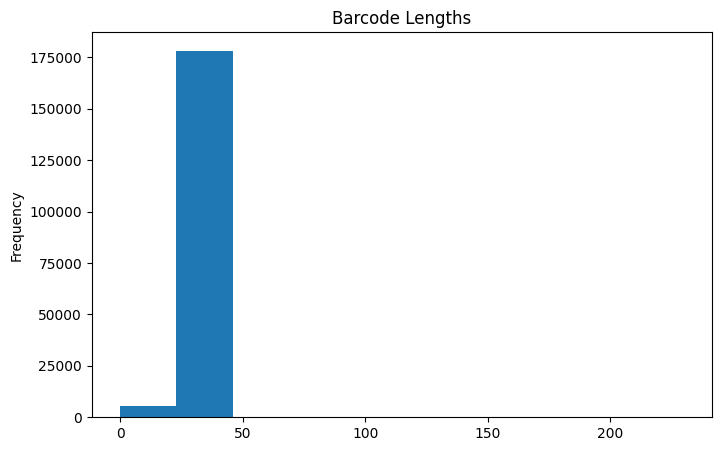

In [22]:
fig_barcode_lengths, axs_barcode_lengths = plt.subplots( figsize=(8,5) )
barcodes['barcode'].apply(len).plot.hist(title='Barcode Lengths', ax=axs_barcode_lengths)

In [23]:
jpbio.util.export_figure(fig_barcode_lengths, "barcode_lengths", data_directory, experiment)

## Examine the read pairs failing sanity checks

In [24]:
sanity_checks_lookup = {i["id"]:i["label"] for i in sanity_checks}
checks_data_frame = pd.DataFrame(
    [[i, sanity_failures[i], sanity_checks_lookup[i]] for i in sanity_failures],
    columns = ['id', 'count', 'label']
).sort_values('count', ascending=False)

In [25]:
checks_data_frame

,id,count,label
0,any,29343,Any Check
4,barcodes_match,26933,Barcodes Match
3,primers_found,22770,Primers Found
1,id_match,0,IDs Match
2,primer_match,0,Primers Match


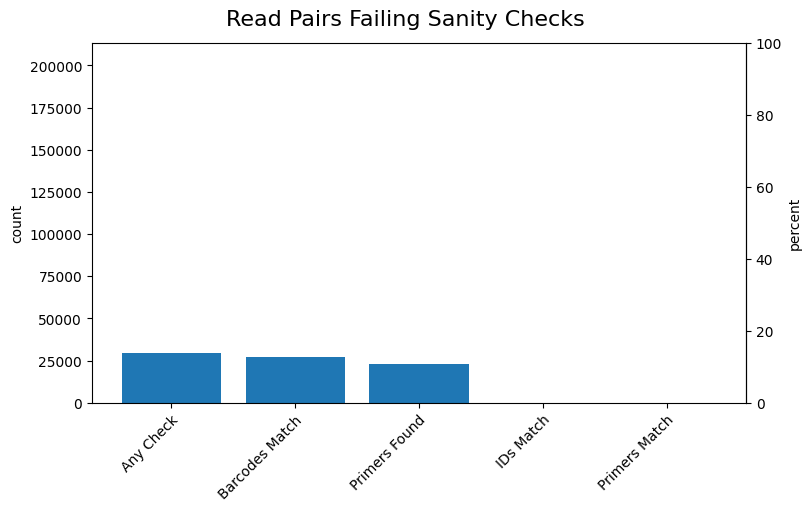

In [26]:
fig_sanity, ax_sanity = plt.subplots(constrained_layout=True, figsize=(8,5))
fig_sanity.suptitle('Read Pairs Failing Sanity Checks', fontsize=16)

ax_sanity.bar(data=checks_data_frame, height='count', x='label')

def n_to_percent(n):
    return 100*n/readNumber

def percent_to_n(p):
    return p*readNumber/100

secax = ax_sanity.secondary_yaxis('right', functions=(n_to_percent, percent_to_n))
secax.set_ylabel('percent')
ax_sanity.set_ylabel('count')
ax_sanity.set_ylim([0, readNumber])
plt.setp(ax_sanity.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [27]:
jpbio.util.export_figure(fig_sanity, "sanity_checks", data_directory, experiment)

## Examine the Overall Read Quality

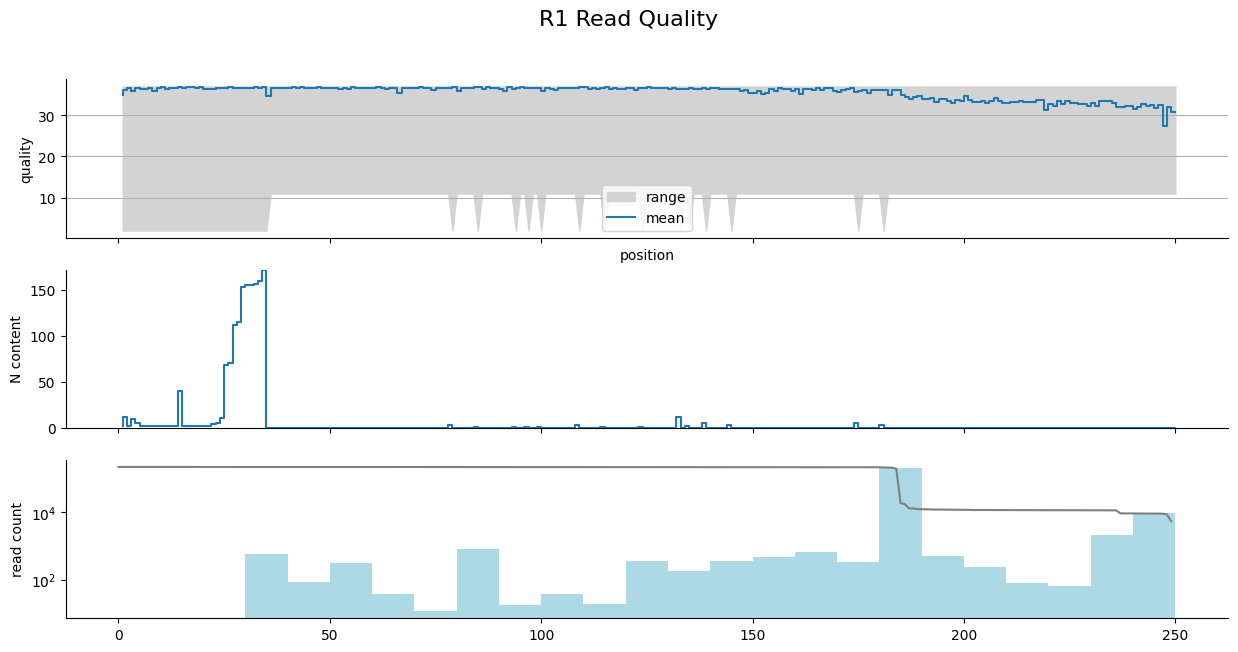

In [28]:
fig_R1 = R1_quality.DiagnosticPlot("R1 Read Quality")

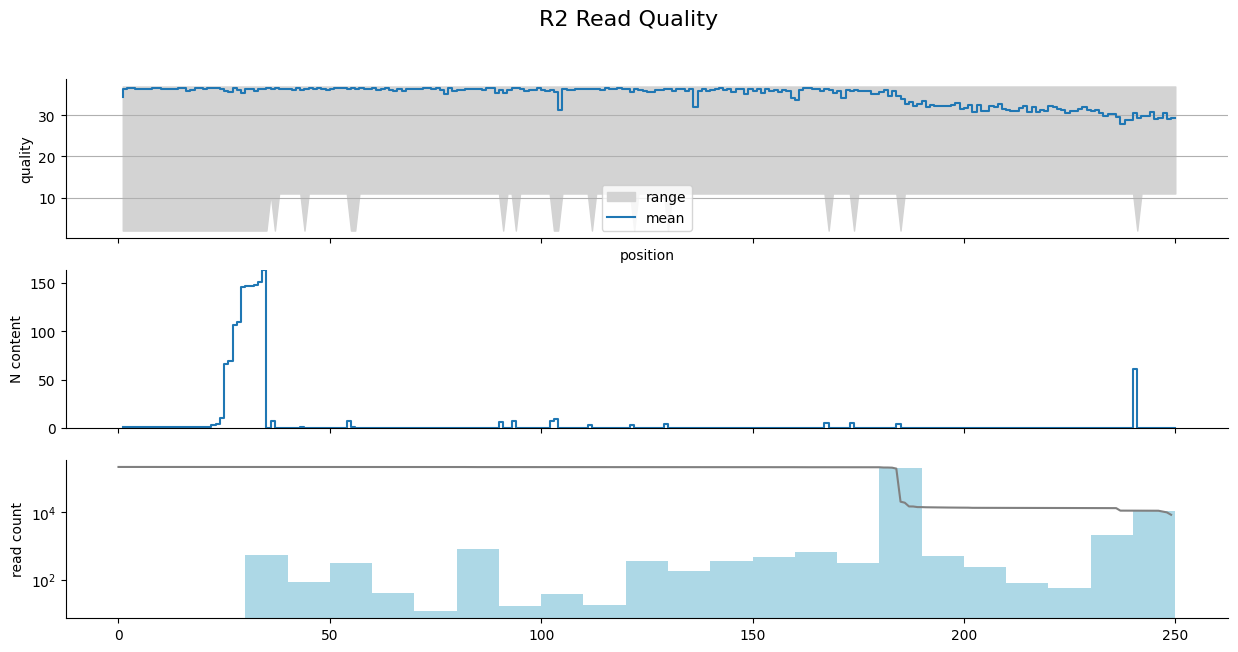

In [29]:
fig_R2 = R2_quality.DiagnosticPlot("R2 Read Quality")

In [30]:
jpbio.util.export_figure(fig_R1, "R1_quality", data_directory, experiment)
jpbio.util.export_figure(fig_R2, "R2_quality", data_directory, experiment)

# Samples Table

<a id='s1'></a>
The `samples.tsv` file should be a tab-separated table of the sample IDs, with row & column labels indicating the primers for that sample.  

Like this:

| | | | | | | | | | | | | | | |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|	| oNB176 | oNB194 | oNB195 | oNB196 | oNB197 | oNB198 | oNB199 | oNB200 | oNB201 | oNB202 | oNB203 | oNB204 |
oNB177 | 2281 | 2282 | 2283 | 2285 | 2286 | 2287 | 2293 | 2294 | 2301 | 2302 | 2306 | 2307 |
oNB205 | 2308 | 2315 | 2316 | 2317 | 2318 | 2331 | 2332 | 2333 | 2334 | 2351 | 2352 | 2353 |
oNB206 | 2354 | 2355 | 2356 | 2357 | 2358 | 2359 | 2360 | 2394 | 2398 | water | Hct116 | c9 |
oNB207 | | | | | | | | | | | | | | | |
oNB208 | | | | | | | | | | | | | | | |
oNB209 | | | | | | | | | | | | | | | |
oNB210 | | | | | | | | | | | | | | | |
oNB211 | | | | | | | | | | | | | | | |


In [31]:
with open(samples_file, 'r') as f:
    samples_table = f.read()
    print(samples_table)

	oVK791	oVK810	oVK811	oVK812	oVK813	oVK814	oVK815	oVK816	oVK817	oVK818	oVK819	oVK820
oVK790	3810	3834	3928	3944	3949	3958	3967	3968	3973	W1	W2	W3
oVK803	3753	3764	3765	3766	3769	3770	3771	3772	3773	3778	3779	3780
oVK804	3782	3783	3784	3785	3804	3836	3731	3749	3752	3754	3755	3762
oVK805	3847	3858	3859	3896	3897	3899	3907	3908	3916	3917	3921	3922
oVK806	3923	4015	4017	4021	4022	4023	W4	719	245	253	280	
oVK807
oVK808
oVK809



In [60]:
primer_name_regex = re.compile(primer_name_regex_string)

def pad_primer(s):
    m = primer_name_regex.match(s)
    if m is not None:
      return m.group(1) + m.group(2).rjust(3, '0')
    else:
      return None

with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]
sample_list = [s for sublist in data for s in sublist if s != '']

In [61]:
sample_dict = {row_headers[r]:{col_headers[c]:'' for c in range(len(col_headers))} for r in range(0, len(row_headers))}
for r in range(len(row_headers)):
  for c in range(0,len(col_headers)):
    try:
      sample_dict[row_headers[r]][col_headers[c]]=data[r][c]
    except:
      pass

In [62]:
sample_dict

{'oVK790': {'oVK791': '3810',
  'oVK810': '3834',
  'oVK811': '3928',
  'oVK812': '3944',
  'oVK813': '3949',
  'oVK814': '3958',
  'oVK815': '3967',
  'oVK816': '3968',
  'oVK817': '3973',
  'oVK818': 'W1',
  'oVK819': 'W2',
  'oVK820': 'W3'},
 'oVK803': {'oVK791': '3753',
  'oVK810': '3764',
  'oVK811': '3765',
  'oVK812': '3766',
  'oVK813': '3769',
  'oVK814': '3770',
  'oVK815': '3771',
  'oVK816': '3772',
  'oVK817': '3773',
  'oVK818': '3778',
  'oVK819': '3779',
  'oVK820': '3780'},
 'oVK804': {'oVK791': '3782',
  'oVK810': '3783',
  'oVK811': '3784',
  'oVK812': '3785',
  'oVK813': '3804',
  'oVK814': '3836',
  'oVK815': '3731',
  'oVK816': '3749',
  'oVK817': '3752',
  'oVK818': '3754',
  'oVK819': '3755',
  'oVK820': '3762'},
 'oVK805': {'oVK791': '3847',
  'oVK810': '3858',
  'oVK811': '3859',
  'oVK812': '3896',
  'oVK813': '3897',
  'oVK814': '3899',
  'oVK815': '3907',
  'oVK816': '3908',
  'oVK817': '3916',
  'oVK818': '3917',
  'oVK819': '3921',
  'oVK820': '3922'},
 '

In [63]:
with open('samples_flat.tsv', 'w', newline='') as tsvfile:
  writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
  for fwd_primer in sample_dict:
    for rev_primer in sample_dict[fwd_primer]:
      row=[fwd_primer,rev_primer,sample_dict[fwd_primer][rev_primer]]
      if sample_dict[fwd_primer][rev_primer] != '':
        print(row)
        writer.writerow(row)
tsvfile.close()

['oVK790', 'oVK791', '3810']
['oVK790', 'oVK810', '3834']
['oVK790', 'oVK811', '3928']
['oVK790', 'oVK812', '3944']
['oVK790', 'oVK813', '3949']
['oVK790', 'oVK814', '3958']
['oVK790', 'oVK815', '3967']
['oVK790', 'oVK816', '3968']
['oVK790', 'oVK817', '3973']
['oVK790', 'oVK818', 'W1']
['oVK790', 'oVK819', 'W2']
['oVK790', 'oVK820', 'W3']
['oVK803', 'oVK791', '3753']
['oVK803', 'oVK810', '3764']
['oVK803', 'oVK811', '3765']
['oVK803', 'oVK812', '3766']
['oVK803', 'oVK813', '3769']
['oVK803', 'oVK814', '3770']
['oVK803', 'oVK815', '3771']
['oVK803', 'oVK816', '3772']
['oVK803', 'oVK817', '3773']
['oVK803', 'oVK818', '3778']
['oVK803', 'oVK819', '3779']
['oVK803', 'oVK820', '3780']
['oVK804', 'oVK791', '3782']
['oVK804', 'oVK810', '3783']
['oVK804', 'oVK811', '3784']
['oVK804', 'oVK812', '3785']
['oVK804', 'oVK813', '3804']
['oVK804', 'oVK814', '3836']
['oVK804', 'oVK815', '3731']
['oVK804', 'oVK816', '3749']
['oVK804', 'oVK817', '3752']
['oVK804', 'oVK818', '3754']
['oVK804', 'oVK819',

In [40]:
barcodes['sample'] = barcodes.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [41]:
barcodes

,barcode,forward_primer,reverse_primer,sample
0,TCTGTCACTCTGTCACACACAGAC,oVK803,oVK816,3772
1,ACACTCTCTCTCTGAGTCACAGAC,oVK803,oVK819,3779
2,TCTGTCTGTGACTGACTGACTCAC,oVK803,oVK814,3770
3,ACAGAGAGACACAGTGAGTGTCTC,oVK806,oVK813,4022
4,TGTCTCTCTCTAAGACACACACTC,oVK806,oVK819,280
...,...,...,...,...
183858,TGACAGTCAGAGTGTGTCTGAGTG,oVK790,oVK816,3968
183859,AGTCTCACTCACACACAGAGACTG,oVK806,oVK818,253
183860,ACACATGTCTGTCACACTCAGAC,oVK803,oVK817,3773
183861,TGTGTGAGAGACAGTGTCACAC,oVK790,oVK810,3834


## Read Count per Sample

In [42]:
counts_by_sample = barcodes.groupby(by='sample').size().reset_index(name='count').sort_values(['count'], ascending=[False])

In [43]:
counts_by_sample

,sample,count
35,3899,4877
40,3921,4863
33,3896,4618
34,3897,4326
31,3858,4233
30,3847,4098
32,3859,4095
52,4021,4056
53,4022,4034
25,3785,3992


<Axes: title={'center': 'Reads Per Sample'}, ylabel='Frequency'>

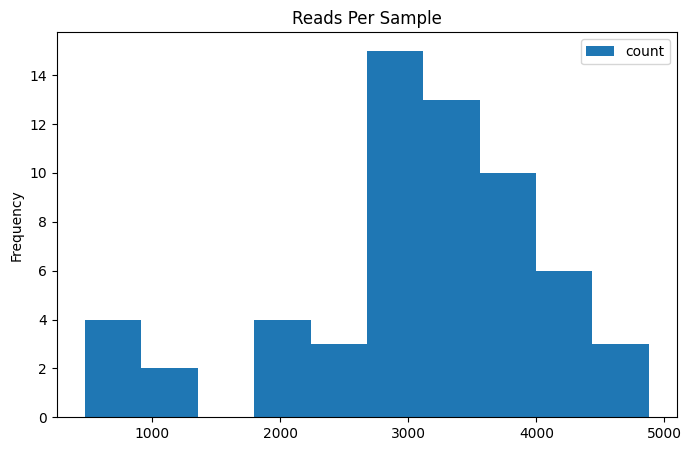

In [44]:
fig_counts_by_sample, axs_counts_by_sample = plt.subplots( figsize=(8,5) )
counts_by_sample.plot.hist(title='Reads Per Sample', ax=axs_counts_by_sample)

In [45]:
jpbio.util.export_figure(fig_counts_by_sample, "counts_by_sample", data_directory, experiment)

# Analysis By Sample

## Top 10 Reads per Sample

In [46]:
counts_table = barcodes.groupby(by=["forward_primer","reverse_primer","sample","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","sample","barcode","count"]
counts_table

,forward_primer,reverse_primer,sample,barcode,count
5,oVK790,oVK791,3810,ACAGTCACAGACTGTCACTCACTC,794
14,oVK790,oVK791,3810,ACTCTGACACTCTGTCTGTCAGAG,721
44,oVK790,oVK791,3810,TCTGTCTGTGACTGACTGACTCAC,187
28,oVK790,oVK791,3810,AGTGAGTCTCTCACAGACTCACAC,141
39,oVK790,oVK791,3810,TCTGACTCTCTCAGTCACACACAC,140
...,...,...,...,...,...
4364,oVK806,oVK820,,TGTCACACTCACACAGACTCTC,1
4367,oVK806,oVK820,,TGTCATGTCAGTGTCTCACAGACTCTC,1
4372,oVK806,oVK820,,TGTGTCAGAGTCTCTCTGTCACTCAGACAGTC,1
4373,oVK806,oVK820,,TGTGTCAGAGTGTGTCTCTCTCAGAC,1


In [47]:
len( counts_table['barcode'].unique() )

1263

In [48]:
counts_table.to_csv('VK022_counts.tsv', sep="\t", index=False)

In [49]:
top_10_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()

In [50]:
top_10_counts_table

,forward_primer,reverse_primer,sample,barcode,count
0,oVK790,oVK791,3810,ACAGTCACAGACTGTCACTCACTC,794
1,oVK790,oVK791,3810,ACTCTGACACTCTGTCTGTCAGAG,721
2,oVK790,oVK791,3810,TCTGTCTGTGACTGACTGACTCAC,187
3,oVK790,oVK791,3810,AGTGAGTCTCTCACAGACTCACAC,141
4,oVK790,oVK791,3810,TCTGACTCTCTCAGTCACACACAC,140
...,...,...,...,...,...
595,oVK806,oVK820,,AGTCTCTCTGTCACTCAGACAGTC,17
596,oVK806,oVK820,,AGTGTGAGTCTCTGTGTGTCTCAC,15
597,oVK806,oVK820,,TGTCACACTCACACTGAGAGTCAG,14
598,oVK806,oVK820,,ACACTCTCTCTCTGAGTCACAGAC,11


In [51]:
top_10_counts_table.to_excel(
    experiment + "_top_10_reads.xlsx",
    sheet_name = "Top 10 Reads"
)

## Water Control
Not working.

ValueError: ignored

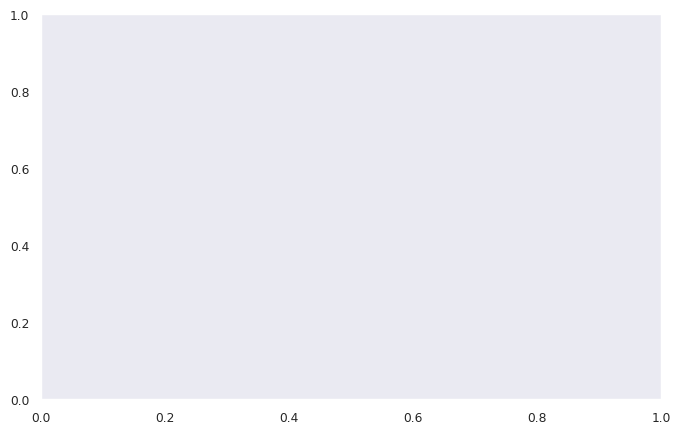

In [70]:
fig_water_counts, axs_water_counts = plt.subplots( figsize=(8,5) )

counts_table[counts_table['sample'] in water_labels].sort_values(
    "count",
    ascending=False
).plot.bar(
    y="count",
    xticks=[],
    figsize=(10,8),
    title='Barcode Counts for Water Control',
    ax=axs_water_counts,
    width=0.9
)

`water_count` is the maximum number of reads for a single barcode found in the water control sample.

In [71]:
water_count = max(counts_table[ counts_table['sample'] in water_labels ]['count'])
water_count

ValueError: ignored

Filter the table of barcode counts by excluding all barcodes with a count less than the maximum count in the water control.

## Analyze Barcode Distribution by Sample

### Interactive Histogram by Sample ID

In [53]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [54]:
samples_list = list( counts_table['sample'].unique() )

In [55]:
@interact
def counts_for_sample(sample=samples_list):
    return counts_table[ counts_table['sample'] == sample ] \
        .head(10) \
        .reset_index(drop=True) \
        .style.bar(subset=['count'],color='lightblue') \
        .hide(axis="index") \
        .hide_columns(['sample','forward_primer','reverse_primer'])

interactive(children=(Dropdown(description='sample', options=('3810', '3834', '3928', '3944', '3949', '3958', …

### Grid of Barcode Counts for All Samples

In [56]:
counts_by_primers = barcodes.groupby(
    by=['forward_primer','reverse_primer','sample']) \
        .size() \
        .reset_index(name='count') \
        .sort_values(['count'], ascending=[False])
counts_by_primers

,forward_primer,reverse_primer,sample,count
41,oVK805,oVK814,3899,4877
46,oVK805,oVK819,3921,4863
39,oVK805,oVK812,3896,4618
40,oVK805,oVK813,3897,4326
37,oVK805,oVK810,3858,4233
36,oVK805,oVK791,3847,4098
38,oVK805,oVK811,3859,4095
51,oVK806,oVK812,4021,4056
52,oVK806,oVK813,4022,4034
27,oVK804,oVK812,3785,3992


Generating this figure is also relatively time-consuming (though not close to the main loop above).

Text(0.5, 0.98, 'VK022B')

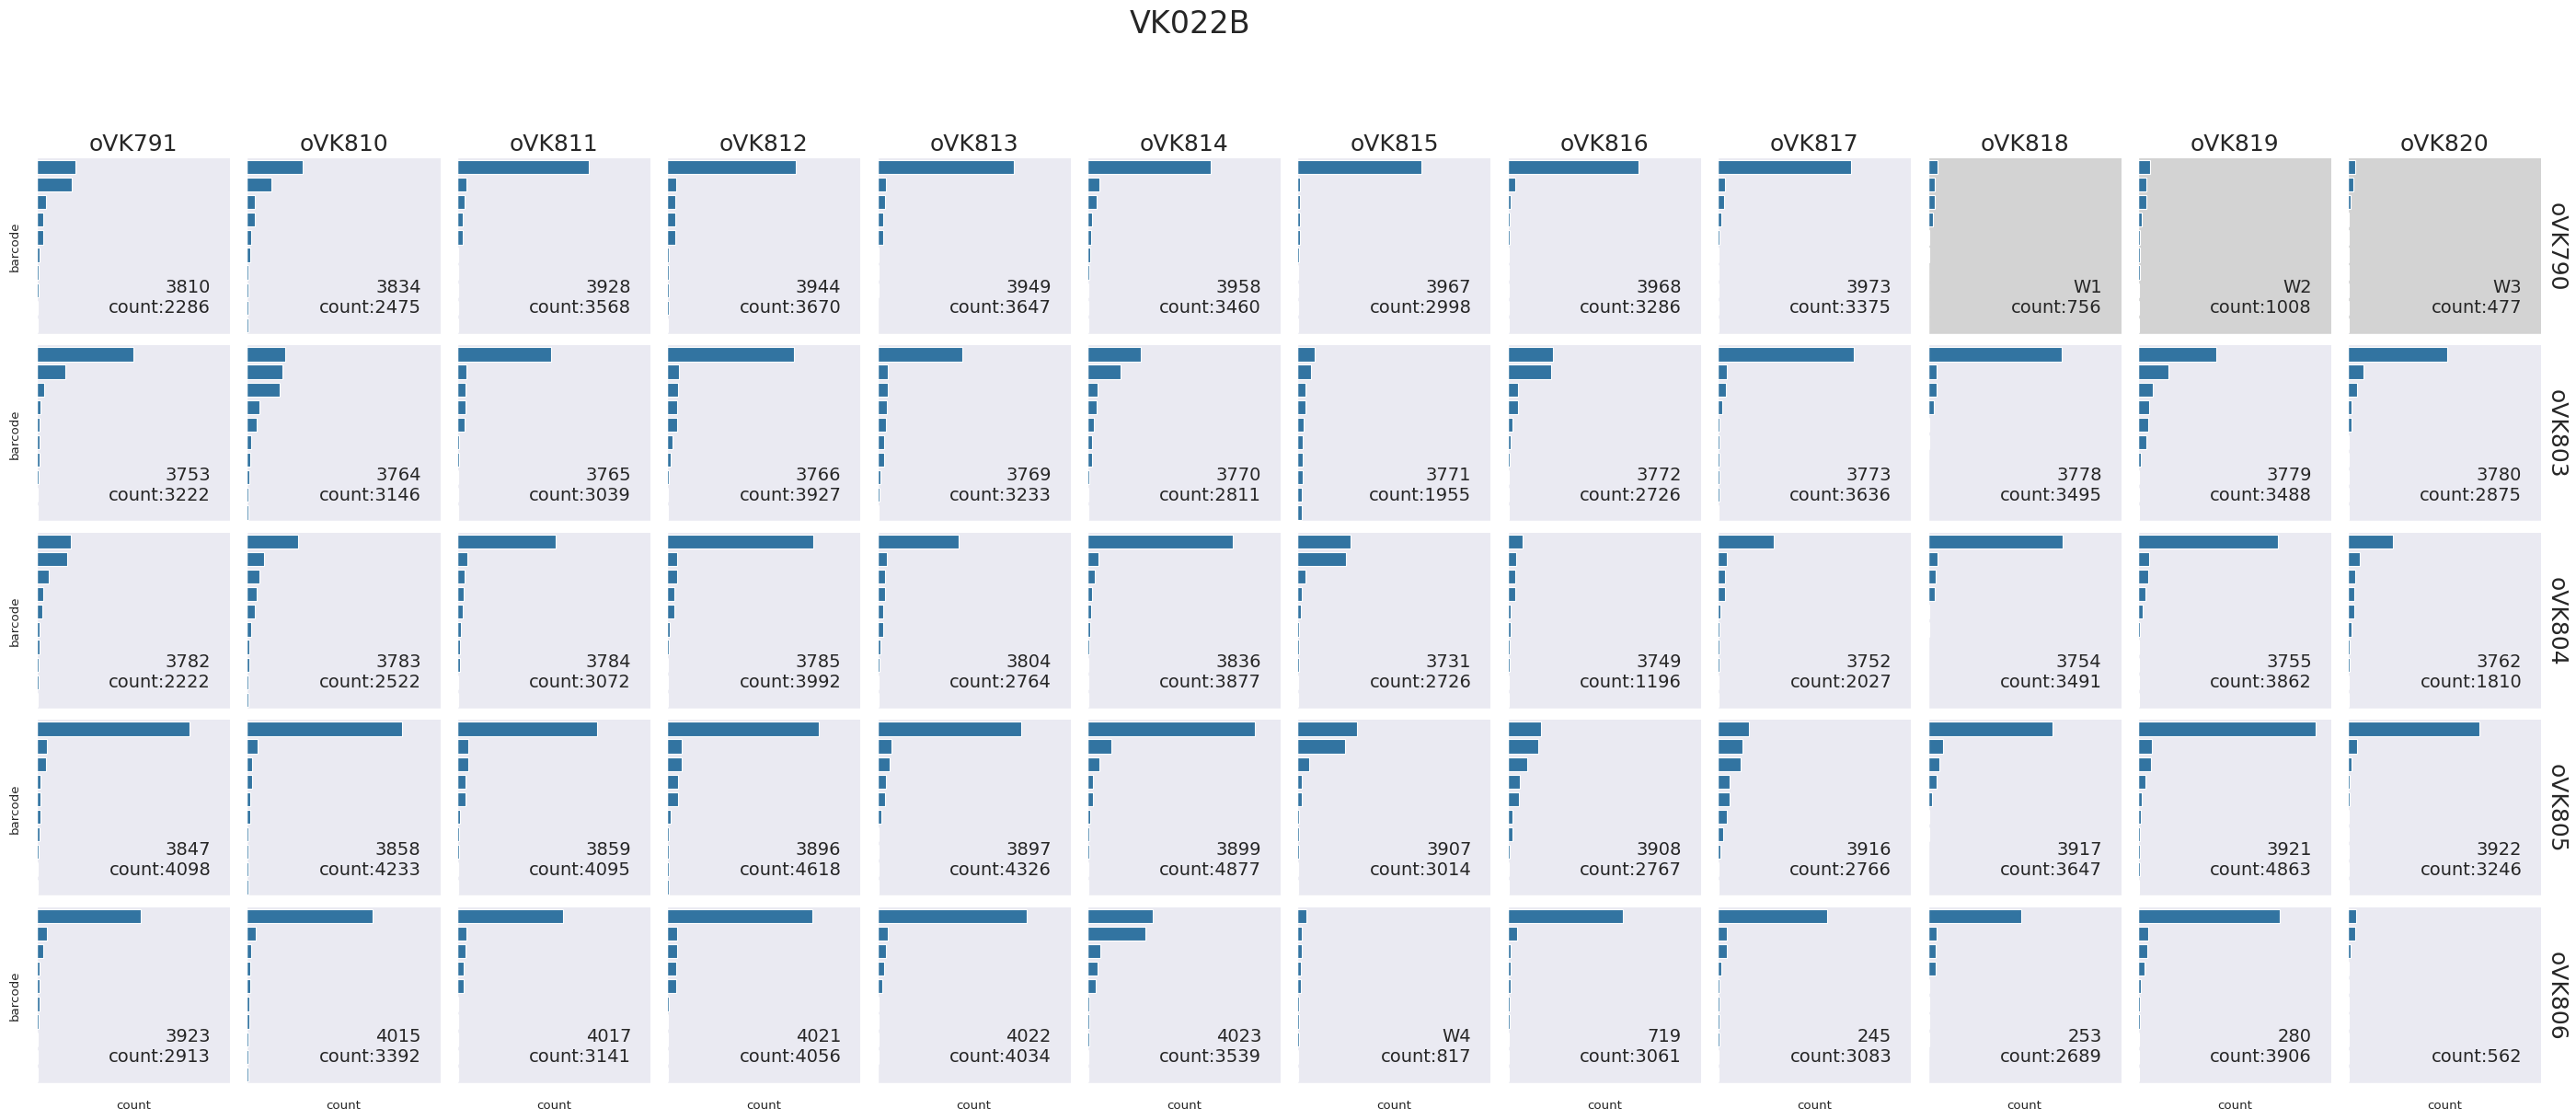

In [68]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = counts_by_primers[(counts_by_primers['forward_primer'] == f) & (counts_by_primers['reverse_primer'] == r)].iloc[0]['count']
    sample = sample_dict[f][r]
    ax = plt.gca()
    if sample in water_labels:
        ax.set_facecolor('lightgrey')

    ax.text(.9, .1, f"{sample}\ncount:{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
hist_grid = sns.FacetGrid(top_10_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
hist_grid.map_dataframe(
    sns.barplot,
    x="count",
    y="barcode",
    # order=counts_table['count'].value_counts().iloc[:5].index,
    orient='h')
hist_grid.map_dataframe(annotate)
hist_grid.set_yticklabels(None)
hist_grid.set_xticklabels(None)
hist_grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.85)
hist_grid.fig.suptitle(experiment, fontsize=24)

In [69]:
jpbio.util.export_figure(hist_grid, "histograms", data_directory, experiment)

In [ ]:
counts_table[ counts_table['count'] > water_count ]

# Other Stuff - Do Not Run

The following cells are work in progress and have not been tested.  The goals are:
1. Find barcodes that appear in more than one sample, and determine which to filter out.
1. Look for an automated way to identify samples that have 1 or 2 dominant barcodes.

## Overlapping Barcodes

In [ ]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

In [ ]:
counts_table[counts_table['barcode'] == bc]

In [ ]:
with open('sample_N_table.csv', 'w') as sample_N:
    print(sample_N_table, file=sample_N)

In [ ]:
counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)

In [ ]:
counts_table.groupby(by='barcode').size().hist(bins=range(0,100), density=True)

In [ ]:
overlaps = counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)
overlaps[(overlaps['count'] < 5) & (overlaps['count'] > 1)]

In [ ]:
counts_and_overlaps = counts_table.set_index('barcode').join(overlaps, how='inner', lsuffix='_reads', rsuffix='_overlaps')
counts_and_overlaps

In [ ]:
bc1 = counts_table['barcode'].iloc[0]
bc1

In [ ]:
h, w = (4,4)
barcode_list = list( counts_table['barcode'].sample(n=h*w) )
# print(barcode_list)
fig, axs = plt.subplots(h, w, figsize=(20,10), sharex=True)

for ax, bc in zip([ax for subaxs in axs for ax in subaxs], barcode_list):
    counts_table[counts_table['barcode'] == bc] \
        .sort_values(by='count', ascending=False) \
        .plot \
        .bar(
            ax=ax,
            xticks=[],
            width=1
        )
plt.show()

In [ ]:
counts_table.groupby('barcode').head()

In [ ]:
counts_table[ counts_table['barcode'] == bc1 ]['count'] \
    .sort_values(ascending=False) \
    .reset_index() \
    .plot \
    .line(
        y='count',
        legend=False)

In [ ]:
N = 100

barcode_list = list( counts_table['barcode'].sample(n=N) )
fig, ax = plt.subplots(figsize=(20,10), sharex=True)

colors = plt.cm.twilight(np.linspace(0,1,N))
for bc, c in zip(barcode_list, colors):
    # print(f'barcode: {bc}\tcolor: {c}')
    counts_table[ counts_table['barcode'] == bc ]['count'] \
        .sort_values(ascending=False) \
        .reset_index() \
        .plot \
        .line(
            ax=ax,
            y='count',
            color=tuple(c),
            legend=False)

In [ ]:
# barcode_list = list( counts_table['barcode'].sample(n=10) )

fig, ax = plt.subplots()
for label, grp in counts_table.groupby('barcode').head():
    # print(grp)
    grp.sort_values(by='count', ascending=False).plot(ax=ax)
    # grp.plot(x = grp.index, y = 'count', ax = ax, label = label)

In [ ]:
counts_and_overlaps[counts_and_overlaps['count_overlap'] == 2]

In [ ]:
counts_and_overlaps[counts_and_overlaps['sample'] == 'water'].sort_values(by='count_overlaps', ascending=False)

In [ ]:
counts_and_overlaps.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .max() \
    .plot(x='count_overlap', y='count_reads', kind='scatter')

In [ ]:
# https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [ ]:
np.random.seed(19680801)
hinton(np.random.rand(20, 20) - 0.5)
plt.show()

## Filter for Clones with 1 or 2 Dominant Barcodes

In [ ]:
z = y.reset_index()
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(z, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="running_percent",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

for ax in g2.axes.flat:
    ax.axvline(x=0.5, color='r', linestyle='-')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
samples_list = [s for sublist in data for s in sublist if s != '']
samples_list

In [ ]:
sample_N_table = {}

@interact
def pick_N_for_sample(sample=samples_list, barcode_count=[1,2,3,4,'many']):
    sample_N_table[sample] = barcode_count
    return counts_table[counts_table['sample']==sample].sort_values("count", ascending=False).head(25).plot.bar(
        y="count",
        xticks=[],
        figsize=(10,5),
        linewidth=1,
        width=1)

In [ ]:
sample_N_table